# Part 1: Can we see the image of the absolute conic?

### Reason for 'Yes': We can calculate the image of the absolute conic  by $\omega = K^{-T} K^{-1}$ 

### Reason for 'No': That is because that the pixels of the calculated image $\omega$ has imaginary part, which can not be shown in a real camera.

### The equation for the image of the absolute conic is very important in camera calibration. The intrinsic matrix of the camera K can be calculated once we know the image of the absolute conic. This calculation can be done without knowing the relation of image fram and world frame (basic without knowing R and t).

# Part 2: Program task

## Summary: 

### The provided dataset works good with both linear and nonlinear camera calibration. The improvement from linear to nonlinear method is small, probably because the linear calibration is already good enough.


### for my own dataset, the corner detection is not as good, but still gives a decent result from the image. 


In [336]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
from numpy.linalg import inv
from numpy import linalg as LA
import math
from random import sample
from scipy.optimize import least_squares
import glob
import BitVector
import numpy as np
import torch
import torch.nn as nn
from sklearn import svm
from sklearn.metrics import confusion_matrix
plt.rcParams.update({'figure.max_open_warning': 0})

# Dataset 1

## Step 1: edge detection

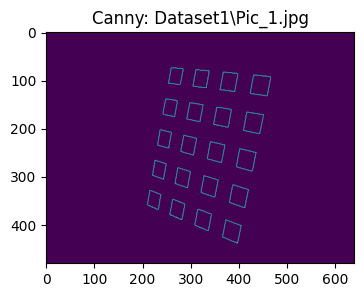

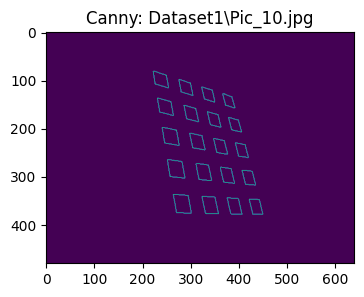

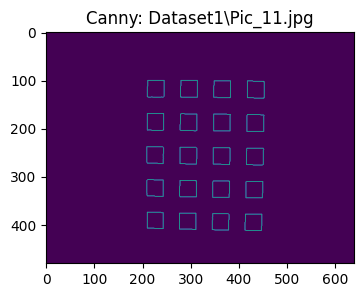

In [337]:
# Canny edge detection
Folder_cur = os.getcwd()
Folder_img1 = os.path.join(Folder_cur,'Dataset1')
Folder_img1 = os.path.join(Folder_cur,'Dataset2')
os.listdir(Folder_img1)

image1_path = glob.glob('Dataset1\*')
image2_path = glob.glob('Dataset2\*')

for i in image1_path[0:3]:
    plt.figure(figsize=(4, 3))
    img = cv.imread(i)
    edges = cv.Canny(img,300,500)

#plt.imshow(img)
    
    plt.imshow(edges)
    plt.title('Canny: '+ i)

## Step 2: Get lines by Hough transform

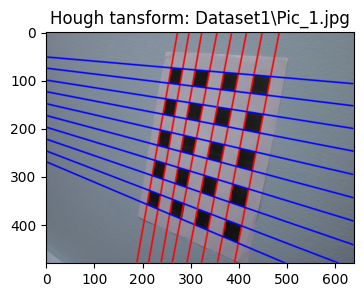

In [338]:
for img_path in image1_path[0:1]:
    plt.figure(figsize=(4, 3))
    img = cv.imread(img_path)
    edges = cv.Canny(img,200,500)
    
    lines = cv.HoughLines(edges, 1, np.pi/180, 55, None, 0, 0)
    lines_paral = []
    lines_perp = []
    
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0] # rho is the distance from the (0,0) to the line
            theta = lines[i][0][1] # theta is the angle between x axis and a line Perpendicular to the line 
            
            # draw a line based on rho and theta 
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 900*(-b)), int(y0 + 900*(a)))
            pt2 = (int(x0 - 900*(-b)), int(y0 - 900*(a)))
            
            # check if the line is horizontal or vertial
            if (abs(theta) < 0.8) or (abs(theta - np.pi)< 0.8):
                # check if the new line is close to a line in the list
                if not lines_paral or True not in (abs(abs(np.array(lines_paral)[:,0]) - abs(rho)) < 12):
                    cv.line(img, pt1, pt2, (255,0,0), 2, cv.LINE_AA)
                    lines_paral.append([rho, theta])
            else:
                # check if the new line is close to a line in the list
                if not lines_perp or True not in (abs(abs(np.array(lines_perp)[:,0]) - abs(rho)) < 12):
                    cv.line(img, pt1, pt2, (0,0,255), 2, cv.LINE_AA)
                    lines_perp.append([rho, theta])
                
    plt.imshow(img)
    plt.title('Hough tansform: ' + img_path)

## Step 3: get the intercept of the lines as corner

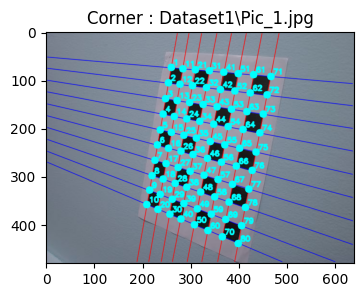

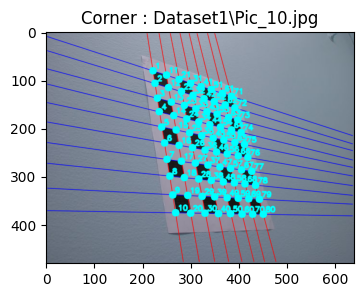

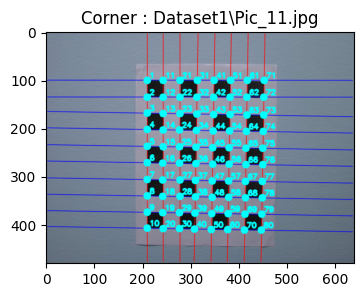

In [339]:
# intersection points of the lines
for img_path in image1_path[0:3]:
    
    img = cv.imread(img_path)
    edges = cv.Canny(img,200,500)
    
    lines = cv.HoughLines(edges, 1, np.pi/180, 55, None, 0, 0)
    lines_paral = []
    lines_perp = []
    corner_point = []
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0] # rho is the distance from the (0,0) to the line
            theta = lines[i][0][1] # theta is the angle between x axis and a line Perpendicular to the line 
            
            # draw a line based on rho and theta 
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 900*(-b)), int(y0 + 900*(a)))
            pt2 = (int(x0 - 900*(-b)), int(y0 - 900*(a)))
            
            # check if the line is horizontal or vertial
            if (abs(theta) < 0.8) or (abs(theta - np.pi)< 0.8):
                # check if the new line is close to a line in the list
                if not lines_paral or True not in (abs(abs(np.array(lines_paral)[:,0]) - abs(rho)) < 12):
                    cv.line(img, pt1, pt2, (255,0,0), 1, cv.LINE_AA)
                    lines_paral.append([rho, theta])
            else:
                # check if the new line is close to a line in the list
                if not lines_perp or True not in (abs(abs(np.array(lines_perp)[:,0]) - abs(rho)) < 12):
                    cv.line(img, pt1, pt2, (0,0,255), 1, cv.LINE_AA)
                    lines_perp.append([rho, theta])
    
    if (len(lines_perp) == 10) and (len(lines_paral) == 8):
    
        #lines_perp.sort(key = lambda x: abs(x[0]))
        #lines_paral.sort(key = lambda x: abs(x[0]))
        lines_perp.sort(key = lambda x: x[0])
        lines_paral.sort(key = lambda x: abs(x[0]))
    
        point_inter = []
        pos = 0

        for line1 in lines_paral:
            for line2 in lines_perp:
                point_inter_pos = lines_inter(line1, line2)
                point_inter.append([point_inter_pos[0],point_inter_pos[1]])
                pos += 1
        
                cv.circle(img, (int(point_inter_pos[0]),int(point_inter_pos[1])), radius=8, color=(0, 255, 255), thickness=-1)
                # image = cv2.putText(image, 'OpenCV', org, font, fontScale, color, thickness, cv2.LINE_AA)
                img = cv.putText(img, str(pos), (int(point_inter_pos[0]+5), int(point_inter_pos[1]-5)), cv.FONT_HERSHEY_SIMPLEX , 0.5, (0, 255, 255), 2, cv.LINE_AA)
        
                point_inter.append([int(point_inter_pos[0]),int(point_inter_pos[1])])
    
    plt.figure(figsize=(4, 3))
    plt.imshow(img)
    plt.title('Corner : ' + img_path)

In [340]:
# a function to get the corner point from an image
def corner_detection(img_path):
    img = cv.imread(img_path)
    
    # canny edge detection
    edges = cv.Canny(img,200,500)
    
    # Hough tranform to get lines from the edges
    lines = cv.HoughLines(edges, 1, np.pi/180, 55, None, 0, 0)
    
    # separate the lines into perp and paral to y axis
    lines_paral = []
    lines_perp = []
    corner_point = []
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0] # rho is the distance from the (0,0) to the line
            theta = lines[i][0][1] # theta is the angle between x axis and a line Perpendicular to the line 
            
            # check if the line is horizontal or vertial
            if (abs(theta) < 0.8) or (abs(theta - np.pi)< 0.8):
                # check if the new line is close to a line in the list
                if not lines_paral or True not in (abs(abs(np.array(lines_paral)[:,0]) - abs(rho)) < 12):
                    lines_paral.append([rho, theta])
            else:
                # check if the new line is close to a line in the list
                if not lines_perp or True not in (abs(abs(np.array(lines_perp)[:,0]) - abs(rho)) < 12):
                    lines_perp.append([rho, theta])
    
    # get the intersection of lines in fixed sequence
    if (len(lines_perp) == 10) and (len(lines_paral) == 8):
    
        # lines_perp.sort(key = lambda x: abs(x[0]))
        lines_perp.sort(key = lambda x: x[0])
        lines_paral.sort(key = lambda x: abs(x[0]))
    
        point_inter = []

        for line1 in lines_paral:
            for line2 in lines_perp:
                point_inter_pos = lines_inter(line1, line2)
                point_inter.append([point_inter_pos[0],point_inter_pos[1]])

        return point_inter
    
    else:
        return []

corner_detection(image1_path[0]);

In [341]:
# image path for good corner detection
def img_path_good_cal(image1_path):
    img_path_good = []
    for img in image1_path:
        if corner_detection(img):
            img_path_good.append(img)
    return img_path_good
img_path_good = img_path_good_cal(image1_path)

# Step 4: Camera Calibration
## 4.1 Choose Pic_11 as the fix img of the given data set

Text(0.5, 1.0, 'Fix pattern for the grid')

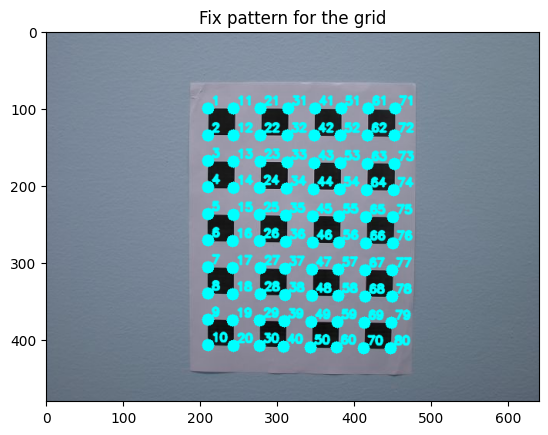

In [342]:
# calculate the homography from image plane to fixed img

# Choose Pic_11 as the fix img of the given data set
img_fix_path = image1_path[2]
img_fix = cv.imread(img_fix_path)
corner_fix = corner_detection(img_fix_path)

pos = 0

for [x,y] in corner_fix:
    pos += 1
    cv.circle(img_fix, (int(x), int(y)), radius=8, color=(0, 255, 255), thickness=-1)        
    img = cv.putText(img_fix, str(pos), (int(x)+5, int(y)-5), cv.FONT_HERSHEY_SIMPLEX , 0.5, (0, 255, 255), 2, cv.LINE_AA)
      
    
plt.imshow(img)
plt.title('Fix pattern for the grid')

Text(0.5, 1.0, 'project one image to the grid pattern with Homo')

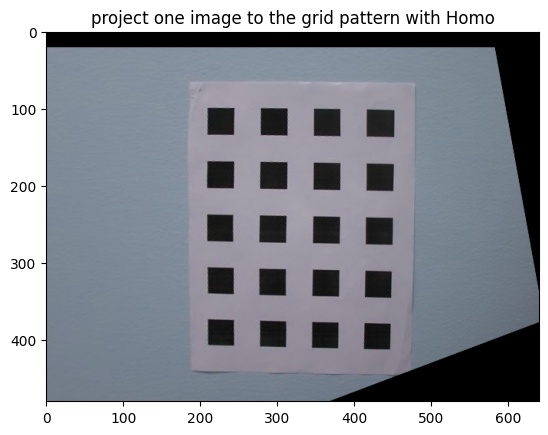

In [343]:
# calculate the homography from pattern to image plane
# to make it faster, I use the OpenCV 
corner_img = corner_detection(image1_path[0])

H,_ = cv.findHomography(np.array(corner_img), np.array(corner_fix), cv.RANSAC)
H

img = cv.imread(image1_path[0])
im1Reg = cv.warpPerspective(img, H, (img.shape[1], img.shape[0]))
plt.imshow(im1Reg)
plt.title('project one image to the grid pattern with Homo')

## 4.2 Calculate Omega

In [344]:
def cal_omega_linear(images_path):
    V_mat = []

    for img_path in image1_path:
    
        corner_img = corner_detection(img_path)
    
        if corner_img:
        
            H,_ = cv.findHomography( np.array(corner_fix), np.array(corner_img),  cv.RANSAC)
        
            [[h11,h21, h31], [h12, h22, h32], [h13, h23, h33]] = H
            vect_12 = [h11*h21, h11*h22 + h12*h21, h12*h22, h13*h21 + h11*h23, h13*h22 + h12*h23, h13*h23]
            vect_11 = [h11*h11, h11*h12 + h12*h11, h12*h12, h13*h11 + h11*h13, h13*h12 + h12*h13, h13*h13]
            vect_22 = [h21*h21, h21*h22 + h22*h21, h22*h22, h23*h21 + h21*h23, h23*h22 + h22*h23, h23*h23]
    
            V_mat.append(vect_12)
            V_mat.append(list(np.array(vect_22) - np.array(vect_11)))
    
    V_mat;   

    # eigen vector of the smallest eigen value of the V_mat.T*V_mat
    V_mat = np.array(V_mat)

    _, eigen_val, eigen_vect = np.linalg.svd(V_mat)
    eigen_val[-1]
    omega_linear_least  = eigen_vect[-1]
    
    return omega_linear_least

cal_omega_linear(image1_path)

array([-1.47433566e-06,  2.56636577e-09, -1.48091175e-06,  5.29910205e-04,
        2.89356862e-04, -9.99999818e-01])

In [306]:
# double check the result V*b
np.matmul(V_mat,omega_linear_least)

array([-3.33664510e-08,  4.22079319e-07,  7.92378049e-07,  2.35804928e-07,
       -3.87930812e-10, -1.19281925e-11,  4.97668840e-07, -8.01161265e-08,
       -2.84809932e-09, -8.44250999e-10,  7.99719103e-08,  2.13535623e-07,
       -8.74324575e-08,  1.89061188e-07, -7.87376061e-08,  3.88967431e-07,
        1.11130781e-07,  7.21309495e-07,  8.51758533e-08,  6.54329862e-07,
       -7.05409405e-08,  3.82806075e-07,  1.05852911e-07,  9.40056634e-07,
       -1.03320938e-07,  4.76527214e-07, -9.66123338e-08,  4.70931024e-07,
       -4.38186143e-08,  9.80328233e-08,  4.11042811e-08,  5.66592714e-08,
        3.86653699e-08,  8.69027925e-08, -3.61697728e-09, -4.82184261e-07,
       -1.37485223e-07, -3.19124269e-07,  2.56663621e-08,  6.30630788e-09,
       -1.09486877e-08,  3.93161647e-08,  6.56493239e-08,  6.18655155e-07,
       -1.08865333e-08,  2.04157618e-08, -1.62453147e-08,  3.45251386e-08,
        2.39847679e-08,  1.33858984e-08,  5.60871361e-08,  1.99158145e-07,
        3.75690882e-08,  

In [345]:
def const_omega(omega):
    w11, w12, w22, w13, w23, w33 = omega
    omega_mat = np.array([[w11,w12,w13],[w12, w22, w23],[w13,w23,w33]])
    
    return omega_mat

const_omega(omega_linear_least)

array([[-6.09100024e-08, -3.87930812e-10,  8.20626635e-05],
       [-3.87930812e-10, -6.09219306e-08,  1.22267059e-04],
       [ 8.20626635e-05,  1.22267059e-04, -9.99999989e-01]])

## 4.3 calculate K from omega

In [346]:
def calculate_K(omega):
    w11, w12, w22, w13, w23, w33 = omega 
    
    y0 = (w12*w13 - w11*w23)/(w11*w22  - w12**2)
 
    Lambda = w33 - (w13**2 + y0*(w12*w13 - w11*w23))/w11

    alpha_x = abs((Lambda/w11))**0.5
    #alpha_x = np.sqrt(Lambda/omega[0])

    alpha_y = abs((Lambda*w11/(w11*w22 - w12**2)))**0.5

    s = - w12 * alpha_x**2 * alpha_y/Lambda

    x0 = s*y0/alpha_y - w13*alpha_x**2/Lambda
    
    K = [[alpha_x, s, x0],
         [0, alpha_y, y0], 
         [0, 0, 1]]
    
    #print(Lambda)
    
    return np.array(K)

# calculate_K(omega_linear_least)
print('Calculate K matrix ' + '<'*20)
calculate_K(omega_linear_least)

Calculate K matrix <<<<<<<<<<<<<<<<<<<<


array([[ 3.25700654e+03, -2.07419974e+01,  1.33454934e+03],
       [ 0.00000000e+00,  3.25675371e+03,  1.99844858e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

## 4.4 calculate the extrinsic parameters of the camera: R+t

In [309]:
def cal_R_t(H, K):
    h1 = [H[0][0], H[1][0], H[2][0]]
    h2 = [H[0][1], H[1][1], H[2][1]]
    h3 = [H[0][2], H[1][2], H[2][2]]
    
    # unit scale factor
    xi_1 = 1/np.linalg.norm(np.matmul(inv(K), h1))
    xi_2 = 1/np.linalg.norm(np.matmul(inv(K), h2))
    xi = np.sqrt(xi_1*xi_2)
    
    #
    r1 = xi* np.matmul(inv(K), h1)
    r2 = xi* np.matmul(inv(K), h2)
    r3 = np.cross(r1, r2)
    r3 = r3 #/np.linalg.norm(r3)
    
    t = xi * np.matmul(inv(K), h3)
    
    R = np.vstack((r1,r2,r3)).T
    
    return R,t


cal_R_t(H,K)

(array([[ 0.99909893,  0.17812697, -0.49786518],
        [-0.14293796,  0.8358189 ,  0.02339391],
        [ 0.58192308,  0.08033467,  0.86052688]]),
 array([-393.09830922, -102.09073978,  416.33713024]))

## 4.5 Reproject, linear -> consider M = [R1, R2, t] 
### Calculate d^2_geom

In [310]:
R,t = cal_R_t(H,K)
print(R,t)

R_t = np.vstack((R.T, t)).T

[[ 0.99909893  0.17812697 -0.49786518]
 [-0.14293796  0.8358189   0.02339391]
 [ 0.58192308  0.08033467  0.86052688]] [-393.09830922 -102.09073978  416.33713024]


Dataset1\Pic_10.jpg  Linear: cost -> 132.99409680599075


[132.99409680599075]

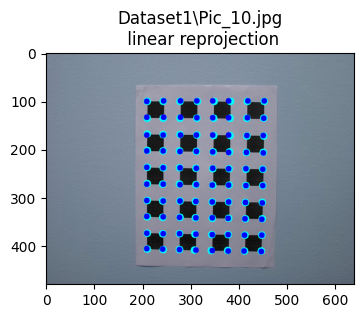

In [311]:
corner_fix = np.array(corner_fix);

dist_geo = []

for img_path in img_path_good[1:2]:
    
    img = cv.imread(img_path)
    img_fix = cv.imread(img_fix_path)
    
    corner_img = corner_detection(img_path)
    corner_img_p = []
    
    H,_ = cv.findHomography( np.array(corner_fix), np.array(corner_img),  cv.RANSAC)
        
    omega = cal_omega_linear(image1_path)
    K = calculate_K(omega)
        
    R,t = cal_R_t(H,K)
    R_t = np.vstack((R[:,0], R[:,1], t)).T
        
    K_R_t = np.matmul(K, R_t)
        
    d_geo_img = 0
        
    for j in range(len(corner_fix)):
        x_f, y_f = corner_fix[j]
        x_i, y_i = corner_img[j] 
            
        corner_point_proj = np.matmul(inv(K_R_t), np.array([x_i,y_i,1]))
        # corner_point_proj = np.matmul(H, np.array([x,y,1]))
            
        x_p, y_p, _  = corner_point_proj /corner_point_proj[-1]
        
            
        d_geo_img += (x_p - x_f)**2 + (y_p - y_f)**2
            
        corner_img_p.append([x_p, y_p])
            
        cv.circle(img_fix, (int(x_f),int(y_f)), radius=8, color=(0, 255, 255), thickness=-1)
        cv.circle(img_fix, (int(x_p),int(y_p)), radius=6, color=(0, 0, 255), thickness=-1)
                
            
    dist_geo.append(d_geo_img)
    plt.figure(figsize=(4, 3))
    plt.imshow(img_fix)
    plt.title(img_path + '\n linear reprojection')
    
    print(img_path,' Linear: cost ->' ,d_geo_img)
dist_geo

In [312]:
def linear_show(img_path):
    
    img = cv.imread(img_path)
    img_fix = cv.imread(img_fix_path)
    
    corner_img = corner_detection(img_path)
    corner_img_p = []
    
    H,_ = cv.findHomography( np.array(corner_fix), np.array(corner_img),  cv.RANSAC)
        
    omega = cal_omega_linear(image1_path)
    K = calculate_K(omega)
        
    R,t = cal_R_t(H,K)
    R_t = np.vstack((R[:,0], R[:,1], t)).T
        
    K_R_t = np.matmul(K, R_t)
        
    d_geo_img = 0
        
    for j in range(len(corner_fix)):
        x_f, y_f = corner_fix[j]
        x_i, y_i = corner_img[j] 
            
        corner_point_proj = np.matmul(inv(K_R_t), np.array([x_i,y_i,1]))
        # corner_point_proj = np.matmul(H, np.array([x,y,1]))
            
        x_p, y_p, _  = corner_point_proj /corner_point_proj[-1]
        
            
        d_geo_img += (x_p - x_f)**2 + (y_p - y_f)**2
            
        corner_img_p.append([x_p, y_p])
            
        cv.circle(img_fix, (int(x_f),int(y_f)), radius=8, color=(0, 255, 255), thickness=-1)
        cv.circle(img_fix, (int(x_p),int(y_p)), radius=6, color=(0, 0, 255), thickness=-1)
                
            
    dist_geo.append(d_geo_img)
    plt.figure(figsize=(4, 3))
    plt.imshow(img_fix)
    plt.title(img_path + 'linear reprojection')
    
    print(img_path,' Linear: cost ->' ,d_geo_img)

## 4.6 reprojection nonlinear (LM algorithm)

In [313]:
# loss function on parameter

def K_R_r_to_para(K, R, t):
    
    R = np.array(R)
    K = np.array(K)
    
    # from R to w_x
    phi = np.arccos((np.trace(R)-1)/2)
    # print(phi)
    [[r11,r12,r13], [r21, r22, r23], [r31, r32, r33]] = R
    
    w = np.array([r32-r23, r13-r31, r21-r12])*(phi/(2*np.sin(phi)))
    
    # alpha_x, s, alpha_y, dx, dy, wx, wy, wz, tx, ty, tz
    para = [K[0,0], K[0,1], K[1,1], K[0,2], K[1,2], w[0], w[1], w[2], t[0], t[1], t[2]]
    
    return para
    
#para = K_R_r_to_para(K, R, t)    

def para_to_K_R_t(para):
    
    t = para[-3:]
    
    alpha_x, s, alpha_y, dx, dy = para[0:5]
    K = np.array([[alpha_x, s, dx], [0, alpha_y, dy], [0,0,1]])
    
    wx, wy, wz = para[5:8]
    w_x = np.array([[0, -wz, wy], [wz, 0, -wx], [-wy, wx, 0]])
    
    phi = np.linalg.norm([wx,wy,wz])
    # print(phi)
    R = np.array([[1,0,0],[0,1,0], [0,0,1]]) + (np.sin(phi)/phi)*w_x + (1-np.cos(phi))/(phi**2)*np.matmul(w_x, w_x)
    
    
    return K,R,t
    
#para_to_K_R_t(para)

def d_geo_reproj(para, corner_img, corner_fix):
    K,R,t = para_to_K_R_t(para)
    
    R_t = np.vstack((R[:,0], R[:,1], t)).T
    K_R_t = np.matmul(K, R_t)
    
    dist = []
    # print(len(corner_fix), len(corner_img))    
    for i in range(len(corner_fix)):
        x_f, y_f = corner_fix[i]
        x_i, y_i = corner_img[i]
        
        corner_point_proj = np.matmul(inv(K_R_t), np.array([x_i,y_i,1]))
        x_p, y_p, _  = corner_point_proj /corner_point_proj[-1]
        
        dist.append((x_f-x_p)**2)
        dist.append((y_f-y_p)**2) 
    
    return dist



img_path = img_path_good[1]

img = cv.imread(img_path)
img_fix = cv.imread(img_fix_path)
    
corner_img = corner_detection(img_path)
    
H,_ = cv.findHomography(np.array(corner_fix), np.array(corner_img),  cv.RANSAC)
        
omega = cal_omega_linear(image1_path)
K = calculate_K(omega)
        
R,t = cal_R_t(H,K)


para = K_R_r_to_para(K, R, t)  

para_to_K_R_t(para)

d_geo_reproj(para, corner_img, corner_fix);

In [314]:
def cal_linear(img_path):

    img = cv.imread(img_path)
    img_fix = cv.imread(img_fix_path)
    
    corner_img = corner_detection(img_path)
    
    H,_ = cv.findHomography(np.array(corner_fix), np.array(corner_img),  cv.RANSAC)
        
    omega = cal_omega_linear(image1_path)
    K = calculate_K(omega)
        
    R,t = cal_R_t(H,K)
    
    return K,R,t

cal_linear(img_path)    
    
def cal_nonlinear(img_path):
    K,R,t = cal_linear(img_path)
    para = K_R_r_to_para(K, R, t)  
    
    img = cv.imread(img_path)
    img_fix = cv.imread(img_fix_path)
    
    corner_img = corner_detection(img_path)
    
    Res = least_squares(d_geo_reproj, para , method = 'lm', args = [corner_img, corner_fix])
    
    K,R,t = para_to_K_R_t(Res.x)
    
    
    # print(path , 'cost ->>>,',  Res.cost)
    
    return K,R,t

# for path in img_path_good:
#     cal_nonlinear(path)

Dataset1\Pic_1.jpg  nonlinear: cost -> 43.654471403067035


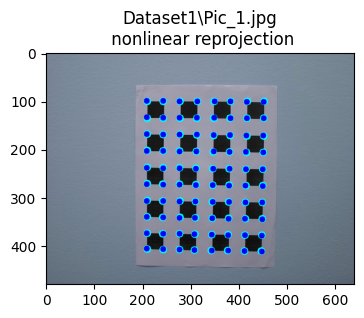

In [315]:
def nonlinear_show(img_path):
    K,R,t = cal_nonlinear(img_path)
    
    corner_img = corner_detection(img_path)
    img_fix = cv.imread(img_fix_path)
    
    R_t = np.vstack((R[:,0], R[:,1], t)).T
        
    K_R_t = np.matmul(K, R_t)
    
    d_geo_img= 0
    for j in range(len(corner_fix)):
        x_f, y_f = corner_fix[j]
        x_i, y_i = corner_img[j] 
            
        corner_point_proj = np.matmul(inv(K_R_t), np.array([x_i,y_i,1]))
        # corner_point_proj = np.matmul(H, np.array([x,y,1]))
            
        x_p, y_p, _  = corner_point_proj /corner_point_proj[-1]
        
            
        d_geo_img += (x_p - x_f)**2 + (y_p - y_f)**2
            
        corner_img_p.append([x_p, y_p])
            
        cv.circle(img_fix, (int(x_f),int(y_f)), radius=8, color=(0, 255, 255), thickness=-1)
        cv.circle(img_fix, (int(x_p),int(y_p)), radius=6, color=(0, 0, 255), thickness=-1)
        
        
            
    dist_geo.append(d_geo_img)
    plt.figure(figsize=(4, 3))
    plt.imshow(img_fix)
    plt.title(img_path + '\n nonlinear reprojection')
    
    print(img_path,' nonlinear: cost ->' ,d_geo_img)

nonlinear_show(choosen_img[0])

## 4.7 compare linear and nonlinear

In [316]:
choosen_img = [img_path_good[0], img_path_good[15]]

choosen_img

['Dataset1\\Pic_1.jpg', 'Dataset1\\Pic_23.jpg']

Dataset1\Pic_1.jpg  nonlinear: cost -> 43.654471403067035
Dataset1\Pic_1.jpg  Linear: cost -> 48.216841677554
Dataset1\Pic_23.jpg  nonlinear: cost -> 62.76416829944876
Dataset1\Pic_23.jpg  Linear: cost -> 66.17112852517056


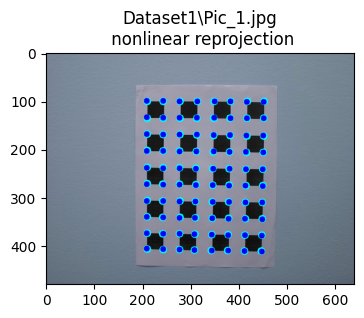

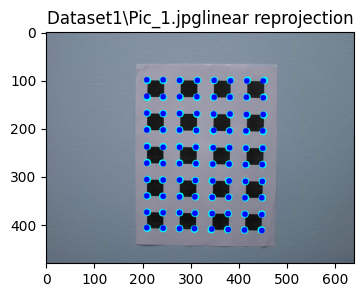

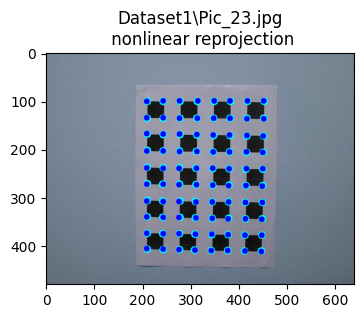

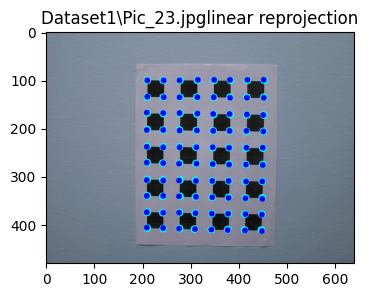

In [317]:
for img in choosen_img:
    nonlinear_show(img)
    linear_show(img)

# My own Data Set

## Step1: Canny edge detection

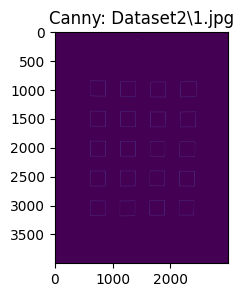

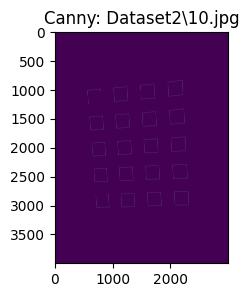

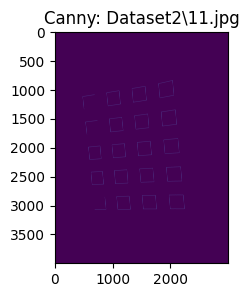

In [318]:
for i in image2_path[0:3]:
    plt.figure(figsize=(4, 3))
    img = cv.imread(i)
    edges = cv.Canny(img,250,400)  
    plt.imshow(edges)
    plt.title('Canny: '+ i)

## Step 2: get lines by Hough transformation

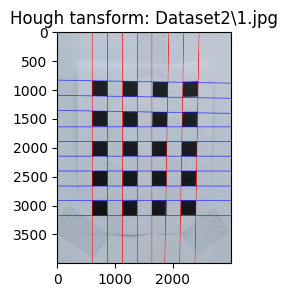

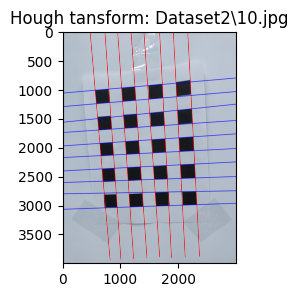

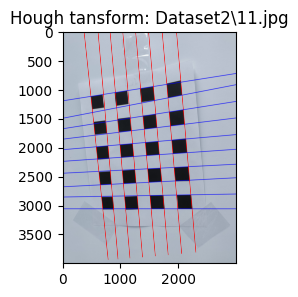

In [319]:
for img_path in image2_path[0:3]:
    plt.figure(figsize=(4, 3))
    img = cv.imread(img_path)
    edges = cv.Canny(img,200,400)
    
    lines = cv.HoughLines(edges, 1, np.pi/180, 130, None, 0, 0)
    lines_paral = []
    lines_perp = []
    
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0] # rho is the distance from the (0,0) to the line
            theta = lines[i][0][1] # theta is the angle between x axis and a line Perpendicular to the line 
            
            # draw a line based on rho and theta 
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 4000*(-b)), int(y0 + 4000*(a)))
            pt2 = (int(x0 - 4000*(-b)), int(y0 - 4000*(a)))
            
            # check if the line is horizontal or vertial
            if (abs(theta) < 0.8) or (abs(theta - np.pi)< 0.8):
                # check if the new line is close to a line in the list
                if not lines_paral or True not in (abs(abs(np.array(lines_paral)[:,0]) - abs(rho)) < 150):
                    cv.line(img, pt1, pt2, (255,0,0), 8, cv.LINE_AA)
                    lines_paral.append([rho, theta])
            else:
                # check if the new line is close to a line in the list
                if not lines_perp or True not in (abs(abs(np.array(lines_perp)[:,0]) - abs(rho)) < 150):
                    cv.line(img, pt1, pt2, (0,0,255), 8, cv.LINE_AA)
                    lines_perp.append([rho, theta])
                
    plt.imshow(img)
    plt.title('Hough tansform: ' + img_path)

## Step 3: intercepts of the lines as corner

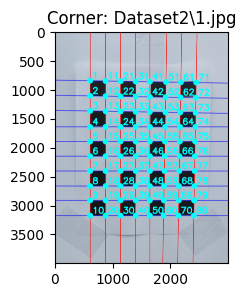

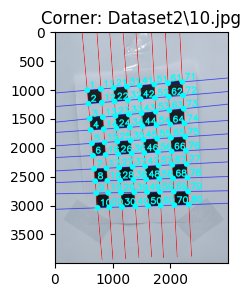

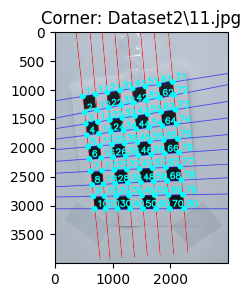

In [320]:
for img_path in image2_path[0:3]:
    
    img = cv.imread(img_path)
    edges = cv.Canny(img,200,400)
    
    lines = cv.HoughLines(edges, 1, np.pi/180, 130, None, 0, 0)
    lines_paral = []
    lines_perp = []
    corner_point = []
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0] # rho is the distance from the (0,0) to the line
            theta = lines[i][0][1] # theta is the angle between x axis and a line Perpendicular to the line 
            
            # draw a line based on rho and theta 
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 4000*(-b)), int(y0 + 4000*(a)))
            pt2 = (int(x0 - 4000*(-b)), int(y0 - 4000*(a)))
            
            # check if the line is horizontal or vertial
            if (abs(theta) < 0.8) or (abs(theta - np.pi)< 0.8):
                # check if the new line is close to a line in the list
                if not lines_paral or True not in (abs(abs(np.array(lines_paral)[:,0]) - abs(rho)) < 150):
                    cv.line(img, pt1, pt2, (255,0,0), 8, cv.LINE_AA)
                    lines_paral.append([rho, theta])
            else:
                # check if the new line is close to a line in the list
                if not lines_perp or True not in (abs(abs(np.array(lines_perp)[:,0]) - abs(rho)) < 150):
                    cv.line(img, pt1, pt2, (0,0,255), 8, cv.LINE_AA)
                    lines_perp.append([rho, theta])
    
    if (len(lines_perp) == 10) and (len(lines_paral) == 8):
    
        #lines_perp.sort(key = lambda x: abs(x[0]))
        #lines_paral.sort(key = lambda x: abs(x[0]))
        lines_perp.sort(key = lambda x: x[0])
        lines_paral.sort(key = lambda x: abs(x[0]))
    
        point_inter = []
        pos = 0

        for line1 in lines_paral:
            for line2 in lines_perp:
                point_inter_pos = lines_inter(line1, line2)
                point_inter.append([point_inter_pos[0],point_inter_pos[1]])
                pos += 1
        
                cv.circle(img, (int(point_inter_pos[0]),int(point_inter_pos[1])), radius=50, color=(0, 255, 255), thickness=-1)
                img = cv.putText(img, str(pos), (int(point_inter_pos[0]+40), int(point_inter_pos[1]-40)), cv.FONT_HERSHEY_SIMPLEX , 5, (0, 255, 255), 20, cv.LINE_AA)
        
                point_inter.append([int(point_inter_pos[0]),int(point_inter_pos[1])])
    
    plt.figure(figsize=(4, 3))
    plt.imshow(img)
    plt.title('Corner: ' + img_path)

In [321]:
# a function to get the corner point from an image
def corner_detection(img_path):
    img = cv.imread(img_path)
    
    # canny edge detection
    edges = cv.Canny(img,200,400)
    
    # Hough tranform to get lines from the edges
    lines = cv.HoughLines(edges, 1, np.pi/180, 130, None, 0, 0)
    
    # separate the lines into perp and paral to y axis
    lines_paral = []
    lines_perp = []
    corner_point = []
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0] # rho is the distance from the (0,0) to the line
            theta = lines[i][0][1] # theta is the angle between x axis and a line Perpendicular to the line 
            
            # check if the line is horizontal or vertial
            if (abs(theta) < 0.8) or (abs(theta - np.pi)< 0.8):
                # check if the new line is close to a line in the list
                if not lines_paral or True not in (abs(abs(np.array(lines_paral)[:,0]) - abs(rho)) <150):
                    lines_paral.append([rho, theta])
            else:
                # check if the new line is close to a line in the list
                if not lines_perp or True not in (abs(abs(np.array(lines_perp)[:,0]) - abs(rho)) < 150):
                    lines_perp.append([rho, theta])
    
    # get the intersection of lines in fixed sequence
    if (len(lines_perp) == 10) and (len(lines_paral) == 8):
    
        # lines_perp.sort(key = lambda x: abs(x[0]))
        lines_perp.sort(key = lambda x: x[0])
        lines_paral.sort(key = lambda x: abs(x[0]))
    
        point_inter = []

        for line1 in lines_paral:
            for line2 in lines_perp:
                point_inter_pos = lines_inter(line1, line2)
                point_inter.append([point_inter_pos[0],point_inter_pos[1]])

        return point_inter
    
    else:
        return []

corner_detection(image2_path[0]);

In [322]:
# image path for good corner detection
img_path_good_2 = img_path_good_cal(image2_path)
print('img_path_good:', len(img_path_good_2))

img_path_good: 25


# Step 4: Camera Calibration
## 4.1 Choose img1 as the fix img of the given data set

Text(0.5, 1.0, 'Fix pattern for the grid')

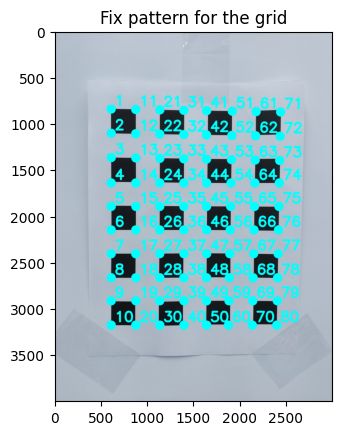

In [323]:
img_fix_path = image2_path[0]
img_fix = cv.imread(img_fix_path)
corner_fix = corner_detection(img_fix_path)

pos = 0

for [x,y] in corner_fix:
    pos += 1
    cv.circle(img_fix, (int(x), int(y)), radius=50, color=(0, 255, 255), thickness=-1)        
    img = cv.putText(img_fix, str(pos), (int(x)+40, int(y)-40), cv.FONT_HERSHEY_SIMPLEX , 5, (0, 255, 255), 20, cv.LINE_AA)
      
    
plt.imshow(img)
plt.title('Fix pattern for the grid')

## 4.2 Calculate omega

In [334]:
def cal_omega_linear(imgs_path):
    V_mat = []

    for img_path in imgs_path:
    
        corner_img = corner_detection(img_path)

        if corner_img:
        
            H,_ = cv.findHomography( np.array(corner_fix), np.array(corner_img),  cv.RANSAC)
        
            [[h11,h21, h31], [h12, h22, h32], [h13, h23, h33]] = H
            vect_12 = [h11*h21, h11*h22 + h12*h21, h12*h22, h13*h21 + h11*h23, h13*h22 + h12*h23, h13*h23]
            vect_11 = [h11*h11, h11*h12 + h12*h11, h12*h12, h13*h11 + h11*h13, h13*h12 + h12*h13, h13*h13]
            vect_22 = [h21*h21, h21*h22 + h22*h21, h22*h22, h23*h21 + h21*h23, h23*h22 + h22*h23, h23*h23]
    
            V_mat.append(vect_12)
            V_mat.append(list(np.array(vect_22) - np.array(vect_11)))
    
    V_mat;  

    # eigen vector of the smallest eigen value of the V_mat.T*V_mat
    V_mat = np.array(V_mat)
    # print(V_mat)
    
    _, eigen_val, eigen_vect = np.linalg.svd(V_mat)
    eigen_val[-1]
    omega_linear_least  = eigen_vect[-1]
    
    return np.array(omega_linear_least)

cal_omega_linear(img_path_good_2)

array([-6.09100024e-08, -3.87930812e-10, -6.09219306e-08,  8.20626635e-05,
        1.22267059e-04, -9.99999989e-01])

In [325]:
omega_linear_least = cal_omega_linear(img_path_good_2)
const_omega(omega_linear_least)

array([[-6.09100024e-08, -3.87930812e-10,  8.20626635e-05],
       [-3.87930812e-10, -6.09219306e-08,  1.22267059e-04],
       [ 8.20626635e-05,  1.22267059e-04, -9.99999989e-01]])

## 4.3 calculate K from omega

In [326]:
print('Calculate K matrix ' + '<'*20)
calculate_K(omega_linear_least)

Calculate K matrix <<<<<<<<<<<<<<<<<<<<


array([[ 3.25700654e+03, -2.07419974e+01,  1.33454934e+03],
       [ 0.00000000e+00,  3.25675371e+03,  1.99844858e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

##  4.4 calculate the extrinsic parameters of the camera: R+t

In [327]:
img = cv.imread(img_path)
img_fix = cv.imread(img_fix_path)
    
corner_img = corner_detection(img_path_good_2[1])
    
H,_ = cv.findHomography( np.array(corner_fix), np.array(corner_img),  cv.RANSAC)

cal_R_t(H,K)

(array([[ 0.97016959,  0.07225405,  0.02647581],
        [-0.13106982,  1.0185388 , -0.00391892],
        [-0.02626204,  0.00208354,  0.9976257 ]]),
 array([-419.5665352 ,  159.82283702,  840.88530297]))

## 4.5 reprojection linear

Dataset2\10.jpg  Linear: cost -> 10959.381836042601


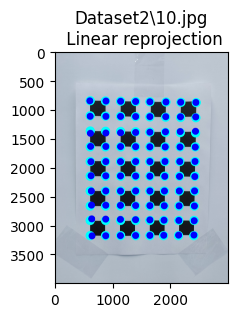

In [328]:
def linear_show(img_path):
    
    img = cv.imread(img_path)
    img_fix = cv.imread(img_fix_path)
    
    corner_img = corner_detection(img_path)
    corner_img_p = []
    
    H,_ = cv.findHomography( np.array(corner_fix), np.array(corner_img),  cv.RANSAC)
        
    omega = cal_omega_linear(image2_path)
    K = calculate_K(omega)
        
    R,t = cal_R_t(H,K)
    R_t = np.vstack((R[:,0], R[:,1], t)).T
        
    K_R_t = np.matmul(K, R_t)
        
    d_geo_img = 0
        
    for j in range(len(corner_fix)):
        x_f, y_f = corner_fix[j]
        x_i, y_i = corner_img[j] 
            
        corner_point_proj = np.matmul(inv(K_R_t), np.array([x_i,y_i,1]))
        # corner_point_proj = np.matmul(H, np.array([x,y,1]))
            
        x_p, y_p, _  = corner_point_proj /corner_point_proj[-1]
        
            
        d_geo_img += (x_p - x_f)**2 + (y_p - y_f)**2
            
        corner_img_p.append([x_p, y_p])
            
        cv.circle(img_fix, (int(x_f),int(y_f)), radius=80, color=(0, 255, 255), thickness=-1)
        cv.circle(img_fix, (int(x_p),int(y_p)), radius=60, color=(0, 0, 255), thickness=-1)
                
            
    dist_geo.append(d_geo_img)
    plt.figure(figsize=(4, 3))
    plt.imshow(img_fix)
    plt.title(img_path + '\n Linear reprojection')
    
    print(img_path,' Linear: cost ->' ,d_geo_img)

linear_show(img_path_good_2[1])

In [329]:
# for img in img_path_good:
#     linear_show(img)

## 4.6 reprojection nonlinear

In [330]:
def cal_linear(img_path):

    img = cv.imread(img_path)
    img_fix = cv.imread(img_fix_path)
    
    corner_img = corner_detection(img_path)
    
    H,_ = cv.findHomography(np.array(corner_fix), np.array(corner_img),  cv.RANSAC)
        
    omega = cal_omega_linear(image2_path)
    K = calculate_K(omega)
        
    R,t = cal_R_t(H,K)
    
    return K,R,t

cal_linear(img_path)    
    
def cal_nonlinear(img_path):
    K,R,t = cal_linear(img_path)
    para = K_R_r_to_para(K, R, t)  
    
    img = cv.imread(img_path)
    img_fix = cv.imread(img_fix_path)
    
    corner_img = corner_detection(img_path)
    
    Res = least_squares(d_geo_reproj, para , method = 'lm', args = [corner_img, corner_fix])
    
    K,R,t = para_to_K_R_t(Res.x)
    
    
    # print(path , 'nonlinear cost ->>>,',  Res.cost)
    
    return K,R,t

# for path in img_path_good:
#     cal_nonlinear(path)

Dataset2\11.jpg  nonlinear: cost -> 21835.961757820576


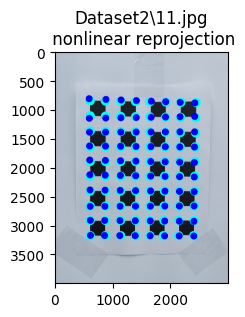

In [331]:
def nonlinear_show(img_path):
    K,R,t = cal_nonlinear(img_path)
    
    corner_img = corner_detection(img_path)
    img_fix = cv.imread(img_fix_path)
    
    R_t = np.vstack((R[:,0], R[:,1], t)).T
        
    K_R_t = np.matmul(K, R_t)
    
    d_geo_img= 0
    
    for j in range(len(corner_fix)):
        x_f, y_f = corner_fix[j]
        x_i, y_i = corner_img[j] 
            
        corner_point_proj = np.matmul(inv(K_R_t), np.array([x_i,y_i,1]))
        # corner_point_proj = np.matmul(H, np.array([x,y,1]))
            
        x_p, y_p, _  = corner_point_proj /corner_point_proj[-1]
        
            
        d_geo_img += (x_p - x_f)**2 + (y_p - y_f)**2
            
        corner_img_p.append([x_p, y_p])
            
        cv.circle(img_fix, (int(x_f),int(y_f)), radius=80, color=(0, 255, 255), thickness=-1)
        cv.circle(img_fix, (int(x_p),int(y_p)), radius=60, color=(0, 0, 255), thickness=-1)
        
        
            
    dist_geo.append(d_geo_img)
    plt.figure(figsize=(4, 3))
    plt.imshow(img_fix)
    plt.title(img_path + '\n nonlinear reprojection')
    
    print(img_path,' nonlinear: cost ->' ,d_geo_img)

nonlinear_show(img_path_good_2[2])

In [332]:
img_choose = [img_path_good_2[2],img_path_good_2[3]]

## 4.7 Compare linear and nonlinear

Dataset2\11.jpg  nonlinear: cost -> 21835.961757820576
Dataset2\11.jpg  Linear: cost -> 35529.84268830217
Dataset2\12.jpg  nonlinear: cost -> 20730.544389856
Dataset2\12.jpg  Linear: cost -> 27112.79394809214


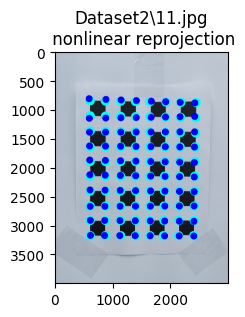

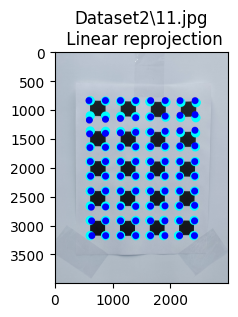

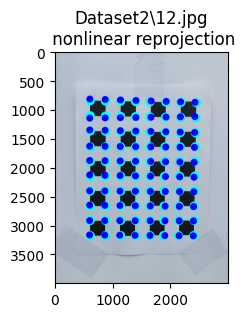

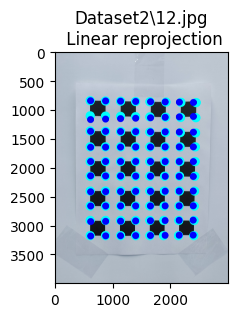

In [333]:
for img in img_choose:
    nonlinear_show(img)
    linear_show(img)